In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [2]:
torch.cuda.set_device(1)

In [3]:
dls_feat = get_3d_dls_feat(Meta.df_comb, path=path_feat_384avg, bs=32)

## Model

In [4]:
xb, yb = dls_feat.one_batch(); xb.shape

torch.Size([32, 60, 512, 8, 8])

In [5]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
#         d_model = 2048+6+1
        d_model = 1024
        n_head = 4
        
        self.flat = nn.Sequential(AdaptiveConcatPool2d(), Flatten())
        self.hook = ReshapeBodyHook(self.flat)
        
#         self.linear = nn.Linear(d_model+7, d_model)
        encoder_layers = TransformerEncoderLayer(d_model, n_head, d_model*2)
        self.transformer = TransformerEncoder(encoder_layers, 4)
        
        self.head = nn.Sequential(nn.Linear(d_model,6))
        
    def forward(self, x):
        x = self.flat(x)
#         x = torch.cat(x, axis=-1)
#         x = self.linear(x)
        feat = self.transformer(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [6]:
m = SeqHead()
name = 'train3d_baseline_feat_transformer'
learn = get_learner(dls_feat, m, name=name)
learn.add_cb(DePadLoss())

In [7]:
xb.shape

torch.Size([32, 60, 512, 8, 8])

In [8]:
# with torch.no_grad():
#     learn.model(xb).shape

In [9]:
# learn.summary()

## Training

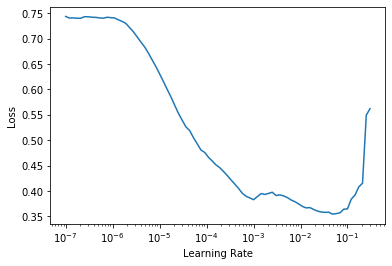

In [11]:
learn.lr_find()

In [8]:
do_fit(learn, 10, 1e-4)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.062358,0.080895,0.975901,0.949774,01:23
1,0.059288,0.070203,0.977365,0.956776,01:25
2,0.055785,0.069116,0.978176,0.957693,01:27
3,0.054553,0.069348,0.977968,0.956203,01:27
4,0.051842,0.068522,0.978496,0.958724,01:29
5,0.051970,0.066579,0.978755,0.959335,01:30
6,0.048816,0.069524,0.978371,0.957082,01:30
7,0.046101,0.066960,0.978503,0.958648,01:31
8,0.045573,0.067521,0.978785,0.958953,01:30
9,0.043777,0.067100,0.978783,0.959144,01:24


## Testing

In [10]:
sub_fn = f'subm/{name}'
learn.load(f'runs/{name}-1')

In [11]:
learn.validate()

(#3) [0.06708242744207382,0.9787170886993408,0.9589025378227234]

In [13]:
learn.dls = get_3d_dls_feat(Meta.df_tst, path=path_feat_tst_384avg, bs=32, test=True)

In [14]:
preds,targs = learn.get_preds()
preds.shape, preds.min(), preds.max()

(torch.Size([121232, 6]), tensor(2.8130e-06), tensor(1.0000))

In [15]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [16]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:03<00:00, 8.04MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [20]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14345908,
 'totalBytes': 27277209,
 'date': '2020-01-31T20:39:14Z',
 'description': 'train3d_baseline_feat_transformer',
 'errorDescription': None,
 'fileName': 'train3d_baseline_feat_transformer.csv',
 'publicScore': '1.47603',
 'privateScore': '0.05434',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14345908/14345908.raw'}